In [3]:
conda activate pyreidolia


Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np 
import pandas as pd
import seaborn as sns
import scicomap as sc
import matplotlib as mpl
import yaml
from pprint import pprint
import cv2
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(1, 'C:/Users/A00006617/OneDrive - Allianz Global Investors/Documents/Allianz Data Scientist/Project/Pyreidolia/scripts/yolo-v4-tf.keras')


#To get a progress bar for long loops:
from tqdm.notebook import trange, tqdm
from time import sleep

#Machine Learning and Deep Learning Packages
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint, EarlyStopping

# Custom package for the project, save all the functions into appropriate sub-packages
from pyreidolia.plot import set_my_plt_style, plot_cloud, plot_rnd_cloud, draw_label_only
from pyreidolia.mask import bounding_box, rle_to_mask, get_binary_mask_sum, mask_to_rle
from pyreidolia.img import get_resolution_sharpness

# Custom package for the YOLO model - see https://github.com/taipingeric/yolo-v4-tf.keras
from models import Yolov4
from utils import read_annotation_lines, DataGenerator


In [8]:
# Where is my yaml ? "C:/Users/A00006617/OneDrive - Allianz Global Investors/Documents/Allianz Data Scientist/Project/Pyreidolia/paths.yml"

paths_yml = input("where is the paths.yml config file?")
with open(paths_yml, "r+") as ymlfile:
    path_dic = yaml.load(ymlfile, Loader=yaml.FullLoader)

pprint(path_dic)

where is the paths.yml config file?C:/Users/A00006617/OneDrive - Allianz Global Investors/Documents/Allianz Data Scientist/Project/Pyreidolia/paths.yml
{'data': {'docs': 'C:/Users/A00006617/OneDrive - Allianz Global '
                  'Investors/Documents/Allianz Data '
                  'Scientist/Project/Pyreidolia/data/',
          'test': 'C:/Users/A00006617/OneDrive - Allianz Global '
                  'Investors/Documents/Allianz Data '
                  'Scientist/Project/Pyreidolia/data/test_images/',
          'train': 'C:/Users/A00006617/OneDrive - Allianz Global '
                   'Investors/Documents/Allianz Data '
                   'Scientist/Project/Pyreidolia/data/train_images/'},
 'notebooks': 'C:/Users/A00006617/OneDrive - Allianz Global '
              'Investors/Documents/Allianz Data '
              'Scientist/Project/Pyreidolia/notebooks/',
 'output': 'C:/Users/A00006617/OneDrive - Allianz Global '
           'Investors/Documents/Allianz Data '
           'Scie

In [9]:
train_csv_path = path_dic['data']['docs'] + 'train.csv'
train_pq_path = path_dic['data']['docs'] + "train_info_clean.parquet"
class_name_path = path_dic['data']['docs'] + 'YOLO/cloud_classes.txt'
checkpoint_path = path_dic['data']['docs'] + 'checkpoints/'
log_path = path_dic['data']['docs'] + 'logs/'

train_data = path_dic['data']['train'] 
test_data = path_dic['data']['test'] 
report_path = path_dic['reports']


## Load pre-processed data

In [10]:
#Load the cleaned training meta-data
train_doc = pd.read_parquet(train_pq_path)
train_doc.head(4)
#and convert to grouped-masks dataframe to obtain one row per image_id
grouped_labels = train_doc.loc[train_doc.is_mask, :].groupby('image_id').agg({'label': lambda x: list(x)})
grouped_labels["label_comb"] = grouped_labels["label"].str.join("-")

In [11]:
#Load X_train2 and X_valid2 - containing rows of arrays with the pixels of the pre-processed images from train_doc
# already split in validation and test set
with open(path_dic['data']['docs'] + 'X_train2.npy', 'rb') as f:
    X_train2 = np.load(f)

with open(path_dic['data']['docs'] + 'X_valid2.npy', 'rb') as f:
    X_valid2 = np.load(f)
    
#we also load the image_ids of train and test
with open(path_dic['data']['docs'] + 'Img_train2.pkl', 'rb') as f:
    Img_train2 = pd.read_pickle(f)

with open(path_dic['data']['docs'] + 'Img_valid2.pkl', 'rb') as f:
    Img_valid2 = pd.read_pickle(f)

In [12]:
#Load y_train2_IC, y_valid2_IC
with open(path_dic['data']['docs'] + 'y_train2_IC.npy', 'rb') as f:
    y_train2_IC = np.load(f)
    
with open(path_dic['data']['docs'] + 'y_valid2_IC.npy', 'rb') as f:
    y_valid2_IC = np.load(f)

## Import existing YOLO implementation

In [13]:
#Load model with pre-trained weights
yolo_path = path_dic['scripts'] + 'yolo-v4-tf.keras/'
model = Yolov4(weight_path= yolo_path + 'yolov4.weights', 
               class_name_path= yolo_path + 'class_names/coco_classes.txt')

nms iou: 0.413 score: 0.3
all weights read
load from C:/Users/A00006617/OneDrive - Allianz Global Investors/Documents/Allianz Data Scientist/Project/Pyreidolia/scripts/yolo-v4-tf.keras/yolov4.weights


C:\Winapp\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


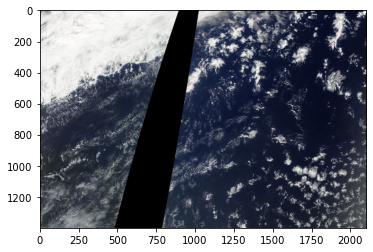

In [17]:
image_name = '7405a00.jpg'

rles = train_doc[train_doc['image_id']==image_name]['encoded_pixels'].reset_index(drop=True)
image_start = plt.imread(os.path.join(train_data, image_name))

fig, ax = plt.subplots()
ax.imshow(image_start) 
plt.show()

img shape:  (500, 700, 3)
# of bboxes: 17


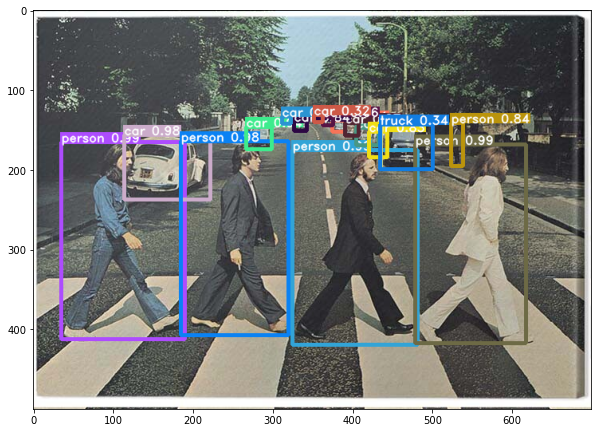

,x1,y1,x2,y2,class_name,score,w,h
0,325,175,482,419,person,0.993533,157,244
1,479,168,618,417,person,0.991794,139,249
2,35,165,190,412,person,0.989919,155,247
3,114,156,222,237,car,0.982551,108,81
4,185,164,320,407,person,0.979576,135,243
5,267,146,299,174,car,0.942703,32,28
6,405,147,433,169,car,0.929916,28,22
7,375,138,391,152,car,0.910109,16,14
8,391,141,408,157,car,0.870634,17,16
9,327,139,343,151,car,0.844430,16,12


In [18]:
model.predict(os.path.join(path_dic['data']['docs'], 'beatles.jpg'))

## Train YOLO based on Cloud images

### Prepare training data

First, we need to create the training data. Yolo requires the input in form of:  
image1.jpg xmin,ymin,xmax,ymax,class_id (xmin,ymin,xmax,ymax,class_id -> in case there are more than one masks per image)  

In [17]:
#We re-create the grouped_masks DF from the EDA, since it will give us all masks per image in one line - as we need it
train_doc = pd.read_csv(train_csv_path)
train_doc = train_doc.rename({'Image_Label': 'image_label', 'EncodedPixels': 'encoded_pixels'}, axis=1)
train_doc[['image_id', 'label']] = train_doc['image_label'].str.split('_', 1, expand=True)
# lets create a dict with class id and encoded pixels and group all the defaults per image
train_doc['label_encodedpix'] = list(zip(train_doc['label'].values, train_doc['encoded_pixels'].values)) 
# Let's create a boolean variable if there is a mask attached to a label
train_doc['is_mask']= ~train_doc.encoded_pixels.isnull().values
grouped_masks = train_doc.loc[train_doc.is_mask, :].groupby('image_id')['label_encodedpix'].apply(list)
grouped_masks

image_id
0011165.jpg    [(Fish, 264918 937 266318 937 267718 937 26911...
002be4f.jpg    [(Fish, 233813 878 235213 878 236613 878 23801...
0031ae9.jpg    [(Fish, 3510 690 4910 690 6310 690 7710 690 91...
0035239.jpg    [(Flower, 100812 462 102212 462 103612 462 105...
003994e.jpg    [(Fish, 2367966 18 2367985 2 2367993 8 2368002...
                                     ...                        
ffcedf2.jpg    [(Fish, 12631 4 12638 3 12649 16 13377 8 13395...
ffd11b6.jpg    [(Flower, 425921 5 425929 4 425945 2 425949 1 ...
ffd3dfb.jpg    [(Sugar, 12891 428 14291 428 15691 428 17091 4...
ffd6680.jpg    [(Flower, 1509467 305 1509773 7 1509782 2 1510...
ffea4f4.jpg    [(Flower, 1194860 675 1196260 675 1197660 675 ...
Name: label_encodedpix, Length: 5546, dtype: object

In [18]:
# Now we only need to extract the bounding boxes (xmin, ymin, xmax, ymax)
#Grouped masks structure grouped_masks[image_ids...][0-3 (loop through the cloud types)][0....n encoded pixels = mask]
class_dict = {'Sugar': 0,
              'Gravel': 1, 
              'Fish': 2,
              'Flower': 3}
dfYoloTrainData = pd.DataFrame(columns = ['Mask_1', 'Mask_2', 'Mask_3', 'Mask_4'])
#Loop to encode the bounding boxes for the YOLO training set 

for img in grouped_masks.index:
    for i in range(len(grouped_masks[img])):
        label = grouped_masks[img][i][0]
        mask = grouped_masks[img][i][1:][0]
        label_code = class_dict[label]
        mask_decoded = rle_to_mask(mask)
        ymin, ymax, xmin, xmax = bounding_box(mask_decoded)
        dfYoloTrainData.loc[img, 'Mask_' + str(i + 1)] = str(xmin) + "," + str(ymin) + "," + str(xmax) + "," +  str(ymax) + "," + str(label_code)
        
dfYoloTrainData.head()   

,Mask_1,Mask_2,Mask_3,Mask_4
0011165.jpg,"189,318,1183,1254,2","968,314,2094,1366,3",NaN,NaN
002be4f.jpg,"167,10,2086,890,2","956,879,2097,1397,3","48,295,944,644,0",NaN
0031ae9.jpg,"2,710,1819,1399,2","1,501,1485,1349,3","470,170,1260,557,0",NaN
0035239.jpg,"72,12,1008,733,3","46,1000,808,1379,1",NaN,NaN
003994e.jpg,"1691,180,2096,663,2","252,517,1238,932,1","20,11,462,499,0",NaN


In [21]:
#Export it to txt file 
dfYoloTrainData.to_csv(path_dic['data']['docs'] + 'YOLO/YoloTrain.txt', header=False, index=True, sep=' ')

### Model Training 

We set-up for model training using the existing functions from the YOLO package.

In [22]:
#We use the existing function from the package to read the prepared training data and create a validation set
 
train_lines, val_lines = read_annotation_lines(path_dic['data']['docs'] + 'YOLO/YoloTrain.txt', test_size=0.1)


In [23]:
#Data Generators for train and validation set 
#Train path already saved in train_data (YAML) 

data_gen_train = DataGenerator(train_lines, class_name_path, train_data)
data_gen_val = DataGenerator(val_lines, class_name_path, train_data)

Set parameters for model training

In [24]:
#Model initialisation - weight_path = None to indicate we want to train the weights
model = Yolov4(weight_path=None, 
               class_name_path=class_name_path,
              )

# We use default model configuration as a starting point  - we can later experiment with other configs for better model quality. 

nms iou: 0.413 score: 0.3


C:\Winapp\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
# We define pathss and callbacks for the model training - inspired from https://neptune.ai/blog/object-detection-with-yolo-hands-on-tutorial
 #We use the Pyredolia / data folder for saving, creating new checkpoints folder
os.makedirs(checkpoint_path, exist_ok = True)
os.makedirs(log_path, exist_ok = True)
 
name4saving = 'epoch_{epoch:02d}-val_loss-{val_loss:.4f}.hdf5'
 
filepath = os.path.join(checkpoint_path, name4saving)
 
rLrCallBack = ReduceLROnPlateau(monitor = 'val_loss',
                                 factor = 0.1,
                                 patience = 5,
                                 verbose = 1)
 
tbCallBack = TensorBoard(log_dir = log_path,
                         histogram_freq = 0,
                         write_graph = False,
                         write_images = False)
 
mcCallBack_loss = ModelCheckpoint(filepath,
                                    monitor = 'val_loss',
                                    verbose = 1,
                                    save_best_only = True,
                                    save_weights_only = False,
                                    mode = 'auto',
                                    save_freq = 'epoch')

esCallBack = EarlyStopping(monitor = 'val_loss',
                              mode = 'min',
                              verbose = 1,
                              patience = 10)

In [ ]:
#Model Training - Warning: Executing the Training cell will require a long run-time
# model.fit(data_gen_train, 
#           initial_epoch=0,
#           epochs=100, 
#           val_data_gen=data_gen_val,
#           callbacks=[rLrCallBack,
#                      tbCallBack,
#                      mcCallBack_loss,
#                      esCallBack]
#          )

Epoch 1/100
624/624 [==============================] - ETA: 0s - loss: 1589.8740 
Epoch 00001: val_loss improved from inf to 333.87933, saving model to C:/Users/A00006617/OneDrive - Allianz Global Investors/Documents/Allianz Data Scientist/Project/Pyreidolia/data/checkpoints\epoch_01-val_loss-333.8793.hdf5


C:\Winapp\Anaconda\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


624/624 [==============================] - 7849s 13s/step - loss: 1589.8740 - val_loss: 333.8793 - lr: 0.0010
Epoch 2/100
624/624 [==============================] - ETA: 0s - loss: 268.1914 
Epoch 00002: val_loss did not improve from 333.87933
624/624 [==============================] - 7370s 12s/step - loss: 268.1914 - val_loss: nan - lr: 0.0010
Epoch 3/100
624/624 [==============================] - ETA: 0s - loss: 254.9239 
Epoch 00003: val_loss improved from 333.87933 to 250.95126, saving model to C:/Users/A00006617/OneDrive - Allianz Global Investors/Documents/Allianz Data Scientist/Project/Pyreidolia/data/checkpoints\epoch_03-val_loss-250.9513.hdf5
624/624 [==============================] - 9154s 15s/step - loss: 254.9239 - val_loss: 250.9513 - lr: 0.0010
Epoch 4/100
624/624 [==============================] - ETA: 0s - loss: 249.2468 
Epoch 00004: val_loss improved from 250.95126 to 248.99417, saving model to C:/Users/A00006617/OneDrive - Allianz Global Investors/Documents/Allianz 

### Testing

In [15]:
# Load the so far best model from the training
weights_latest = checkpoint_path+'epoch_09-val_loss-236.7950.hdf5'
model = Yolov4(weight_path=weights_latest , 
               class_name_path=class_name_path)

nms iou: 0.413 score: 0.3


In [41]:
model.weight_path

'C:/Users/A00006617/OneDrive - Allianz Global Investors/Documents/Allianz Data Scientist/Project/Pyreidolia/data/checkpoints/epoch_04-val_loss-248.9942.hdf5'

img shape:  (1400, 2100, 3)
# of bboxes: 0


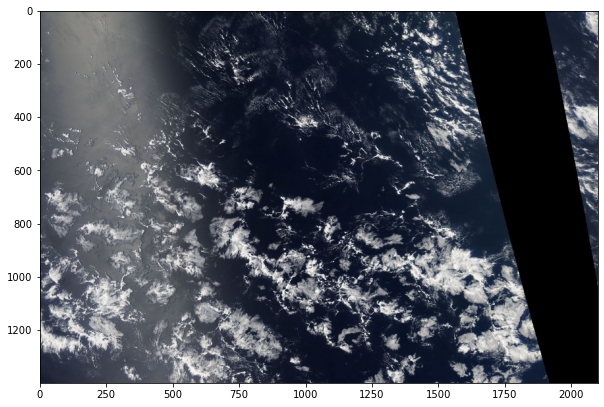

<AxesSubplot:>

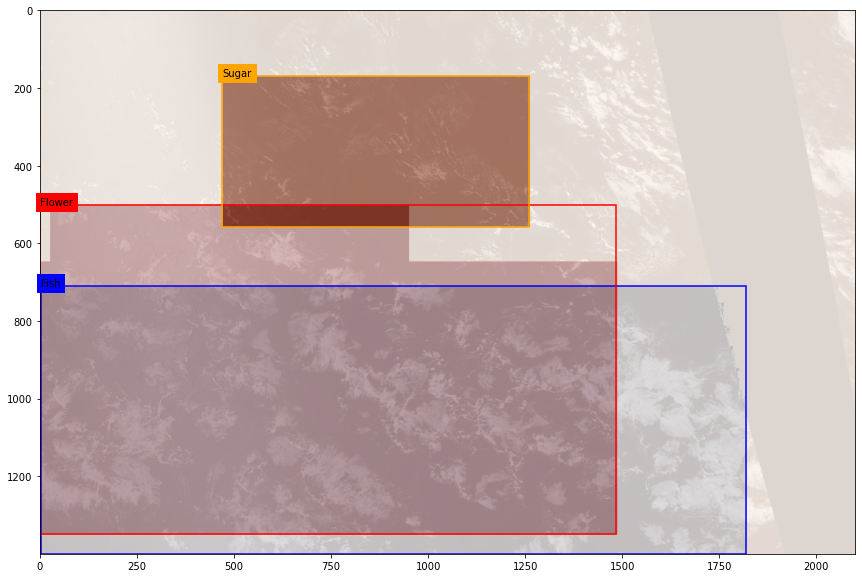

In [20]:
img_ids = ['0011165.jpg', '002be4f.jpg', '0031ae9.jpg', '00dec6a.jpg','0035239.jpg', 'ffcedf2.jpg']
img = img_ids[2]
model.predict(os.path.join(train_data,img))
plot_cloud(img_path=train_data, img_id = img , label_mask = grouped_masks[img])

In [31]:
## Deep-dive for improvement